# Statistical Thinking in Python Part II.

### Acknowledgement
<a id='https://app.datacamp.com/learn/courses/statistical-thinking-in-python-part-2'>DataCamp</a>

### Table of Contents

## Parameter Estimation by Optimization

Datasets in Usage
- `ml_nohitters.csv`
- `female_literacy_fertility.csv`

### Example 1: 
### Q1. How often do we get no-hitters?

The number of games played between each no-hitter in the modern era (1901-2015) of Major League Baseball is stored in the array nohitter_times.

If we assume that no-hitters are described as a **Poisson process**, then the time between no-hitters is **Exponentially** distributed. As we have seen, the ___Exponential distribution___ has a single parameter, which we will call $\tau$, the typical interval time. The value of the parameter  that makes the exponential distribution best match the data is the mean interval time (where time is in units of *number of games*) between no-hitters.

In the following, we will

- Compute the mean time (in units of number of games) between no-hitters.
- Draw 100,000 samples from an Exponential distribution with the parameter we computed from the mean of the inter-no-hitter times.
- Plot the theoretical PDF using plt.hist() and see whether our obsevations match with the theoretical curve or not.

In [1]:
from embedded_data import nohitter_times
from calc_helper import ecdf

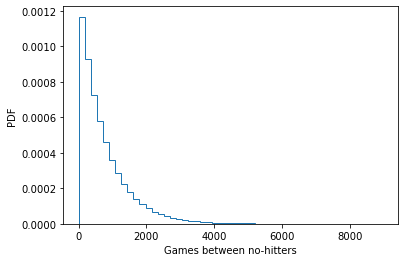

In [2]:
# Seed random number generator
np.random.seed(42)

# Compute mean no-hitter time: tau
tau = np.mean(nohitter_times)

# Draw out of an exponential distribution with parameter tau: inter_nohitter_time
inter_nohitter_time = np.random.exponential(tau, 100_000)

# Plot the PDF and label axes
plt.figure()
_ = plt.hist(inter_nohitter_time,
             bins=50, 
             density=True, 
             histtype='step')

_ = plt.xlabel('Games between no-hitters')
_ = plt.ylabel('PDF')



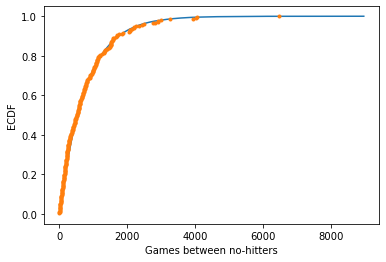

In [3]:
# Create a CDF from theoretical samples: x_theor, y_theor
x_theor, y_theor = ecdf(inter_nohitter_time)

# Create a CDF from observational samples: x, y
x, y = ecdf(nohitter_times)

# CDF curve for theoretical calcs
plt.plot(x_theor, y_theor)

# CDF scatters for observations
plt.plot(x, y, marker='.', linestyle='none')

# Adjust general properties
plt.xlabel('Games between no-hitters')
plt.ylabel('ECDF');

___Comment:___ It looks like no-hitters in the modern era of Major League Baseball are Exponentially distributed. Based on the story of the Exponential distribution, this suggests that they are a random process; when a no-hitter will happen is independent of when the last no-hitter was.

### Q2. How is this parameter optimal?

Now sample out of an exponential distribution with $\tau$ being **twice as large** as the optimal $\tau$. Do it again for $\tau$ **half as large**. Make CDFs of these samples and overlay them with your data. You can see that they do not reproduce the data as well. Thus, the $\tau$ you computed from the mean inter-no-hitter times is optimal in that it best reproduces the data.

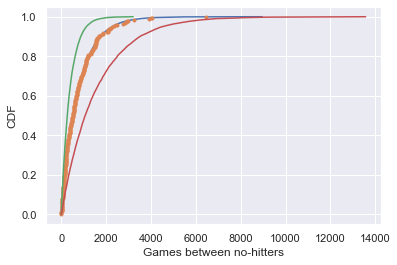

In [4]:
# Plot the theoretical CDFs
sns.set()
plt.plot(x_theor, y_theor)
plt.plot(x, y, marker='.', linestyle='none')
plt.margins(0.05)
plt.xlabel('Games between no-hitters')
plt.ylabel('CDF')

# Take samples with half tau: samples_half
samples_half = np.random.exponential(tau/2, 10000)

# Take samples with double tau: samples_double
samples_double = np.random.exponential(tau*2, 10000)

# Generate CDFs from these samples
x_half, y_half = ecdf(samples_half)
x_double, y_double = ecdf(samples_double)

# Plot these CDFs as lines
_ = plt.plot(x_half, y_half)
_ = plt.plot(x_double, y_double)

# Show the plot
plt.show()

### Example 2: Female Illiteracy and Fertility

Next, we will look at the correlation between female literacy and fertility (defined as the average number of children born per woman) throughout the world. For ease of analysis and interpretation, we will work with the illiteracy rate.

It is always a good idea to do some EDA ahead of our analysis. To this end, plot the fertility versus illiteracy and compute the Pearson correlation coefficient. The NumPy array `illiteracy` has the illiteracy rate among females for most of the world's nations. The array `fertility` has the corresponding fertility data.

In [5]:
from embedded_data import illiteracy, fertility
from calc_helper import ecdf, pearson_r
from viz_helper import print_eq

0.8041324026815341


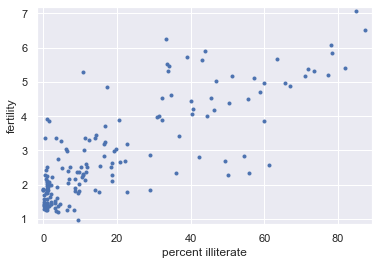

In [6]:
# Plot the illiteracy rate versus fertility
_ = plt.plot(illiteracy, fertility, marker='.', linestyle='none')

# Set the margins and label axes
plt.margins(.02)
_ = plt.xlabel('percent illiterate')
_ = plt.ylabel('fertility')

# Show the Pearson correlation coefficient
print(pearson_r(illiteracy, fertility))

___Comment:___ We can see the correlation between illiteracy and fertility by eye, and by the substantial Pearson correlation coefficient of 0.8. It is difficult to resolve in the scatter plot, but there are many points around near-zero illiteracy and about 1.8 children/woman.

slope = 0.04979854809063423 children per woman / percent illiterate
intercept = 1.888050610636557 children per woman

    fertility = 0.0498*illiteracy + 1.8881
    


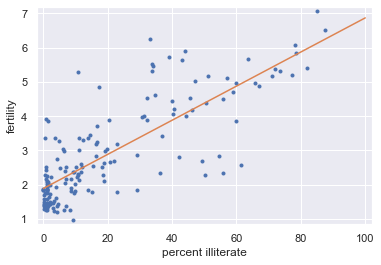

In [7]:
# Plot the illiteracy rate versus fertility
_ = plt.plot(illiteracy, fertility, marker='.', linestyle='none')
plt.margins(0.02)
_ = plt.xlabel('percent illiterate')
_ = plt.ylabel('fertility')

# Perform a linear regression using np.polyfit(): a, b
slope, intercept = np.polyfit(illiteracy, fertility, deg=1)

# Print the results to the screen
print('slope =', slope, 'children per woman / percent illiterate')
print('intercept =', intercept, 'children per woman')

# Make theoretical line to plot
x = np.array([0, 100])
y = slope * x + intercept

# Add regression line to your plot
_ = plt.plot(x, y)

# Output equation
print_eq(slope, intercept, 'illiteracy', 'fertility')

### How is it optimal?

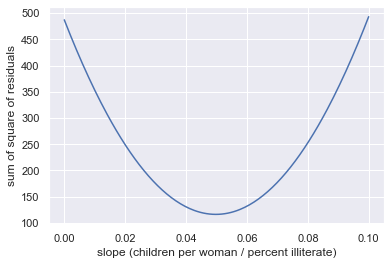

In [8]:
# Specify slopes to consider: a_vals
slope_vals = np.linspace(0, .1, 200)

# Initialize sum of square of residuals: rss
rss = np.empty_like(slope_vals)

# Compute sum of square of residuals for each value of a_vals
for i, slope_val in enumerate(slope_vals):
    rss[i] = np.sum((fertility - slope_val*illiteracy - intercept)**2)
    
# Plot the RSS
plt.plot(slope_vals, rss)
plt.xlabel('slope (children per woman / percent illiterate)')
plt.ylabel('sum of square of residuals');

In [9]:
opt_slope = slope_vals[np.argmin(rss)]
print("Optimal slope: {:.4f}".format(opt_slope))

Optimal slope: 0.0497


## Bootstrap Confidence Intervals

```python
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, deg=1)

    return bs_slope_reps, bs_intercept_reps
```

### Part 1. One-Dimensinal Bootstrap

#### Q1. Simulate the Sampling Distribution of Means

**Dataset**: `sheffield_weather_station.csv`

In this part, we will compute a bootstrap estimate of the **probability density function (PDF)** of the ___mean annual rainfall___ at the Sheffield Weather Station. Remember, we are estimating the mean annual rainfall we would get if the Sheffield Weather Station could repeat all of the measurements from 1883 to 2015 over and over again. This is a probabilistic estimate of the mean. You will plot the PDF as a histogram, and you will see that it is Normal.

In fact, it can be shown theoretically that under not-too-restrictive conditions, the value of the mean will always be Normally distributed. (This does not hold in general, just for the mean and a few other statistics.) The standard deviation of this distribution, called the **standard error of the mean, or SEM**, is given by the standard deviation of the data divided by the square root of the number of data points. I.e., for a data set, sem = np.std(data) / np.sqrt(len(data)). Using hacker statistics, we get this same result without the need to derive it, but we will verify this result from your bootstrap replicates.

The dataset has been pre-loaded for you into an array called rainfall.

In [10]:
from bootstrap import draw_bs_reps

In [11]:
# Load in data
weather_df = pd.read_csv('datacamp_data/sheffield_weather_station.csv', skiprows=8, sep='\s+')
weather_df.head()

,yyyy,mm,tmax,tmin,af,rain,sun
0,1883,1,6.3,1.7,6,122.1,---
1,1883,2,8.0,2.8,2,69.8,---
2,1883,3,4.8,-1.6,23,29.6,---
3,1883,4,12.2,3.8,2,74.0,---
4,1883,5,14.7,6.2,0,31.2,---


In [12]:
weather_df.yyyy.min(), weather_df.yyyy.max()

(1883, 2016)

In [13]:
# Choose rainfall between year 1883 and 2015 only
rainfall = weather_df[weather_df['yyyy']<=2015].groupby('yyyy')['rain'].sum().to_numpy()
len(rainfall)

133


Theoretical SEM from population std: 10.511
Calculated SEM from bs_samples: 10.466



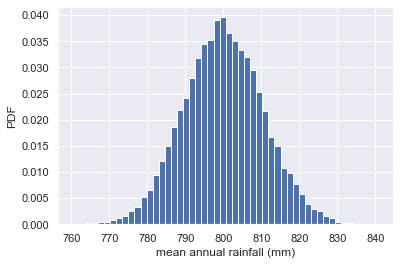

In [14]:
np.random.seed(42)
# Take 10,000 bootstrap replicates of the mean: bs_replicates
bs_replicates_rainfall = draw_bs_reps(rainfall, np.mean, 10000)

# Calculate theoretical SEM
sem = np.std(rainfall) / np.sqrt(len(rainfall))

# Calculate standard deviation of bootstrap replicates
bs_std = np.std(bs_replicates_rainfall)

# Output result
output = """
Theoretical SEM from population std: {:.3f}
Calculated SEM from bs_samples: {:.3f}
"""
print(output.format(sem, bs_std))

# Make a histogram of the results
_ = plt.hist(bs_replicates_rainfall, bins=50, density=True)
_ = plt.xlabel('mean annual rainfall (mm)')
_ = plt.ylabel('PDF')

####  Q2. What is the 95% confidence interval?

**Dataset**: 
- `sheffield_weather_station.csv`

A confidence interval gives upper and lower bounds on the range of parameter values you might expect to get if we repeat our measurements. For named distributions, you can compute them analytically or look them up, but one of the many beautiful properties of the bootstrap method is that you can take percentiles of your bootstrap replicates to get your confidence interval. Conveniently, you can use the `np.percentile()` function.

Next we use the bootstrap replicates just generated to compute the 95% confidence interval.

In [15]:
def ci_intervals(ci):
    baseline = np.around((100-ci)/2, 2)
    lower_bound = baseline
    upper_bound = 100 - baseline
    return [lower_bound, upper_bound]

In [16]:
# Find 95% CI for the sampling mean
np.percentile(bs_replicates_rainfall, ci_intervals(95))

array([779.76992481, 820.95043233])

**Dataset**: 
- `mlb_nohitters.csv`

95% confidence interval = [660.67280876 871.63077689] games


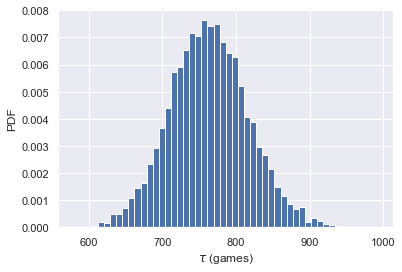

In [17]:
np.random.seed(42)
# Draw bootstrap replicates of the mean no-hitter time (equal to tau): bs_replicates
bs_replicates_nohitters = draw_bs_reps(nohitter_times, np.mean, 10000)

# Compute the 95% confidence interval: conf_int
conf_int = np.percentile(bs_replicates_nohitters, ci_intervals(95))

# Print the confidence interval
print('95% confidence interval =', conf_int, 'games')

# Plot the histogram of the replicates
_ = plt.hist(bs_replicates_nohitters, bins=50, density=True)
_ = plt.xlabel(r'$\tau$ (games)')
_ = plt.ylabel('PDF')


#### Q3. Bootstrap Replicates of Other Statistics

We saw in the previous cells that **the mean is Normally distributed**. This ___does not___ necessarily hold for other statistics, but we can always take bootstrap replicates! 

In the following, we'll generate bootstrap replicates for the **variance of the annual rainfall** at the Sheffield Weather Station and plot the histogram of the replicates.

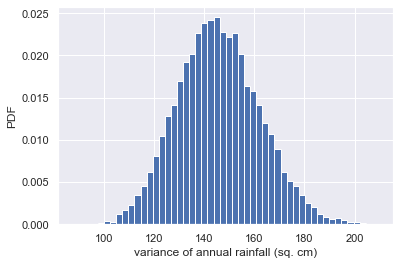

In [18]:
np.random.seed(42)
# Generate 10,000 bootstrap replicates of the variance
bs_replicates_var_rainfall = draw_bs_reps(rainfall, np.var, 10000)

# Unit conversion: put the variance in units of square centimeters
bs_replicates_var_rainfall /= 100

# Make a histogram of the results
_ = plt.hist(bs_replicates_var_rainfall, bins=50, density=True)
_ = plt.xlabel('variance of annual rainfall (sq. cm)')
_ = plt.ylabel('PDF')

___Comment:___ This is not normally distributed, as it has a longer tail to the right. But we can still compute a confidence interval on the variance, or any other statistic, using `np.percentile()` with the bootstrap replicates.

### Part 2. Pair-wise Bootstrap


Pairs bootstrap involves resampling pairs of data. Each collection of pairs fit with a line, in this case using `np.polyfit()`. We do this again and again, getting bootstrap replicates of the parameter values.

#### Q1. What is the 95% Confidence Interval for the Slope of a Line?

**Dataset**
- `illiteracy/fertility data`

In [22]:
# import importlib, bootstrap
# importlib.reload(bootstrap)

<module 'bootstrap' from '/Users/alejandrosanz/Downloads/projects_on_GitHub/POC/Statistics/bootstrap.py'>

In [23]:
from bootstrap import draw_bs_pairs_linreg

[0.04454992 0.05547932]


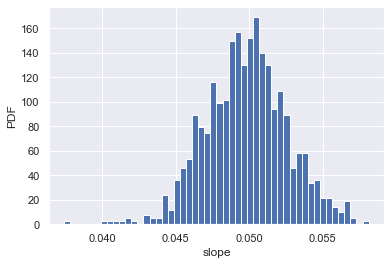

In [27]:
# Generate replicates of slope and intercept using pairs bootstrap
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(illiteracy, fertility, 1000)

# Compute and print 95% CI for slope
print(np.percentile(bs_slope_reps, ci_intervals(95)))

# Plot the histogram
plt.figure()
_ = plt.hist(bs_slope_reps, bins=50, density=True)
_ = plt.xlabel('slope')
_ = plt.ylabel('PDF')

#### Q2. Plotting Bootstrap Linear Regression

A nice way to visualize the variability we might expect in a linear regression is to plot the line you would get from each bootstrap replicate of the slope and intercept. 

In the following, we'll do this for the first 100 of bootstrap replicates of the slope and intercept.

**Dataset**
- `illiteracy/fertility data`

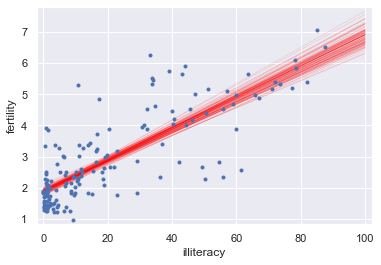

In [28]:
# Generate array of x-values for bootstrap lines: x
x = np.array([0, 100])

# Plot the bootstrap lines
plt.figure()
for i in range(100):
    _ = plt.plot(x, 
                 bs_slope_reps[i]*x + bs_intercept_reps[i],
                 linewidth=0.5, alpha=0.2, color='red')

# Plot the data
_ = plt.plot(illiteracy, fertility, linestyle='none', marker='.')

# Label axes, set the margins, and show the plot
_ = plt.xlabel('illiteracy')
_ = plt.ylabel('fertility')
plt.margins(0.02)